# Experimental Results for Paper

## House prices

In [1]:
import dp4gp_datasets
import dp4gp
import random
import numpy as np
import GPy
import matplotlib.pyplot as plt
%matplotlib inline



warning in stationary: failed to import cython module: falling back to numpy


Skip this if you want, and load precomputed data from the csv file below:

In [ ]:
#region's boundaries
london_east = 530000
london_north = 180000
size = 50000

#dp4gp_datasets.setup_postcodes('') #only needs calling once
c = dp4gp_datasets.load_prices_and_postcode()

samp = (c['easting']>london_east-size) & (c['easting']<london_east+size) & (c['northing']>london_north-size) & (c['northing']<london_north+size)
c = c[samp]
c = c.ix[random.sample(c.index, 3000)]

#adds column of highest qualifications
c = dp4gp_datasets.add_ons_column(c,'QS501EW')

Load precomputed dataset:

In [16]:
import pandas as pd
c = pd.read_csv('price_dataset.csv')

Get it into a form we'll be able to predict over

In [27]:
c = c[c['years']>2005]

In [28]:
#east, north, time, education -> price
training_inputs = np.vstack([c['easting'].values,c['northing'].values,c['seconds'].values,(c['QS501EW_6']/c['QS501EW_0']).values]).T
training_inputs = training_inputs[:,0:2]
ys = c['price'].values

In [29]:
ys[:,None].shape

(1287, 1)

In [30]:
training_inputs.shape

(1287, 2)

In [41]:
#squash data into £0k-£1M range
ys[ys>1e6] = 1e6
ys[ys<0] = 0
sens = 1e6-0

#rbf = GPy.kern.RBF(4,700e3,[15e3,15e3,50*31536000, 10.0],ARD=True)
rbf = GPy.kern.RBF(training_inputs.shape[1],1000e3,[15e3,15e3],ARD=True)
mod = GPy.models.GPRegression(training_inputs,ys[:,None],rbf)
mod.Gaussian_noise = 2000e3

dpgp = dp4gp.DPGP_cloaking(mod,sens,1.0,0.01)

#p = mod.plot(fixed_inputs=fixed_inputs,legend=False)
#xlim = p.axes.get_xlim()
#print xlim
#Xtest = 
#mu = dpgp.draw_prediction_samples(Xtest,20)
#dpgp.plot(fixed_inputs=[(1,180000),(2,np.max(c['seconds'])),(3,1)])
#plt.ylim([-2,2])

1 180000.0
.
Stopped before convergence


 dp4gp.py:331: RuntimeWarning:covariance is not positive-semidefinite.


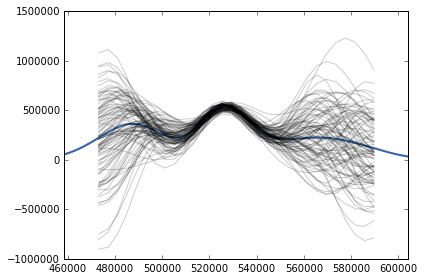

In [46]:
#fixed_inputs=[(1,130e3),(2,np.max(c['seconds'])),(3,1)]
fixed_inputs=[(1,180e3)]

coords = []
free_inputs = []
for i,(start,finish) in enumerate(np.array([np.min(mod.X,0),np.max(mod.X,0)]).T):
    if i not in [f[0] for f in fixed_inputs]:
        extra = (finish-start)*0.1
        linspace = np.linspace(start-extra,finish+extra,30)
        coords.append(linspace)
        free_inputs.append(i)
coords = np.array(coords)

if len(coords)==2:
    xs,ys = np.meshgrid(coords[0,:],coords[1,:])
    xs = xs.flatten()
    ys = ys.flatten()
else:
    xs = coords[0,:]
    
Xtest = np.zeros([len(xs),mod.X.shape[1]])
for f in fixed_inputs:
    print f[0],f[1]
    Xtest[:,f[0]] = f[1]

Xtest[:,free_inputs[0]] = xs
if len(coords)==2:
    Xtest[:,free_inputs[1]] = ys
N = 100

preds = dpgp.draw_prediction_samples(Xtest,N)

plt.figure(figsize=[12,12])
p = mod.plot(fixed_inputs=fixed_inputs,legend=False,plot_data=False)
#xlim = p.axes.get_xlim()
#Xtest = np.arange(xlim[0],xlim[1],(xlim[1]-xlim[0])/100.0)[:,None]
#Xtest = np.array([[520e3,180e3,np.max(c['seconds']),1]]);
#mu = dpgp.draw_prediction_samples(Xtest,N)

if len(coords)==2:
    scaledpreds = 100*preds[:,0] / np.max(preds[:,0])
    plt.scatter(xs,ys,scaledpreds)
if len(coords)==1:
    plt.plot(xs,preds,alpha=0.2,color='black')

(0, 1000000.0)

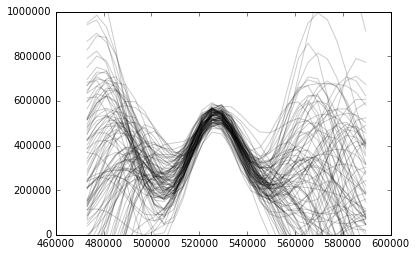

In [47]:
if len(coords)==2:
    scaledpreds = 100*preds[:,0] / np.max(preds[:,0])
    plt.scatter(xs,ys,scaledpreds)
if len(coords)==1:
    plt.plot(xs,preds,alpha=0.2,color='black')
plt.ylim([0,1e6])

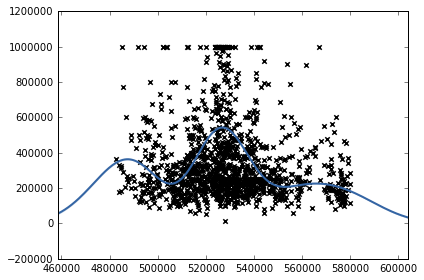

In [49]:
dpgp.model.plot(fixed_inputs=fixed_inputs,legend=False)

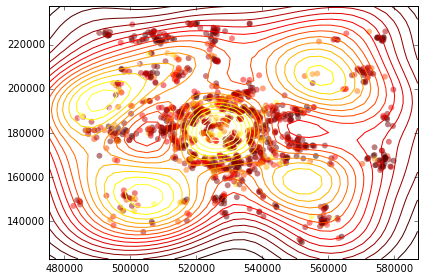

In [48]:
dpgp.model.plot(legend=False)